# IMPORT PACKAGE

In [200]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
%matplotlib inline
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


# IMPORT DATASET

In [201]:
df = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_submission = pd.read_csv('../input/sample_submission.csv')

# DATA EXPLORATION

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [203]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [204]:
df.describe().drop("count")

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
mean,1.534950,1.664530,-73.973486,40.750921,-73.973416,40.751800,9.594923e+02
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5.237432e+03
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735885,3.970000e+02
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,6.620000e+02
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,1.075000e+03
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,3.526282e+06


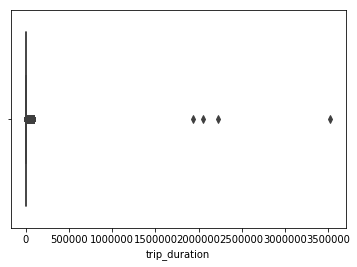

In [205]:
sns.boxplot(x=df['trip_duration']);
#On peut observer que des données ne peuvent etre prise en compte, il va faloir filtrer 

# ADD COLUMN DATE AND DISTANCE

In [206]:
import math

def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [207]:
def distance (df):
    df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                                 df['pickup_longitude'].values, 
                                                 df['dropoff_latitude'].values,
                                                 df['dropoff_longitude'].values)
    return df

In [208]:
#fonction recuperation des dates

def rescu_date (df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['hour'] = df['pickup_datetime'].dt.hour
    df['weekday'] = df['pickup_datetime'].dt.weekday
    df['minute'] = df['pickup_datetime'].dt.minute
    

    return df

In [209]:
#Ajout de la colonne distance
df = distance(df)
#Ajout des columns date 
rescu_date(df);

# FILTER DATA

In [210]:
#Suite au check des datas, on procede au filtre du dataset

#Filtre les lignes avec moins d'une heure de trajet 
df = df[(df.trip_duration < 3600)]

#On récupere les coordonnées cohérente 
df = df[(df.dropoff_latitude < 41)]
df = df[(df.dropoff_latitude > 40)]

df = df[(df.dropoff_longitude > -79)]
df = df[(df.dropoff_longitude < -72)]

df = df[(df.pickup_latitude < 51)]
df = df[(df.passenger_count > 0)]

#On ne prend pas en compte les distance de trajet nul
df = df[(df.distance > 0)]

# CHECK DATA

In [211]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,year,month,day,hour,weekday,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,2016,3,14,17,0,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,2016,6,12,0,6,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,2016,1,19,11,1,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,2016,4,6,19,2,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,2016,3,26,13,5,30


In [212]:
df.describe().drop("count") #Permet d'afficher les valeurs non scientifiques

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,year,month,day,hour,weekday,minute
mean,1.533756,1.663422,-73.974205,40.751290,-73.973753,40.752028,812.892265,3.343534,2016.0,3.513122,15.501113,13.606605,3.052617,29.594310
std,0.498859,1.313294,0.036518,0.027395,0.034751,0.031699,584.411414,3.704687,0.0,1.680432,8.706335,6.411439,1.955396,17.323585
min,1.000000,1.000000,-74.726715,40.099789,-74.711327,40.153744,1.000000,0.000424,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.991905,40.737598,-73.991341,40.736145,396.000000,1.235863,2016.0,2.000000,8.000000,9.000000,1.000000,15.000000
50%,2.000000,1.000000,-73.981819,40.754230,-73.979790,40.754601,658.000000,2.087177,2016.0,4.000000,15.000000,14.000000,3.000000,30.000000
75%,2.000000,2.000000,-73.967674,40.768391,-73.963211,40.769878,1062.000000,3.823745,2016.0,5.000000,23.000000,19.000000,5.000000,45.000000
max,2.000000,8.000000,-73.092278,41.319164,-72.671150,40.998051,3599.000000,112.548872,2016.0,6.000000,31.000000,23.000000,6.000000,59.000000


# FILTER COLUMN

In [213]:
#On selectionne les colonnes à récuperer 
X_column_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'weekday', 
                      'distance', 'minute'];

#On selectionne la target 
y_column_target = ['trip_duration'];

#Fonction qui permet de splitter les collones 
def split_dataset(df):
    X = df[X_column_features]
    y = df[y_column_target]
    return X, y

# IMPORT RANDOM FOREST

In [214]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, SCORERS)
from sklearn.model_selection import cross_val_score
import math

rf = RandomForestRegressor()

In [215]:
X_train, y_train = split_dataset (df)

# SPLIT DATA

In [216]:
#On créé des dataset contenant les données pour le train et on check leurs contenue 
X_train, y_train = split_dataset (df)
X_train.shape, y_train.shape

((1440203, 13), (1440203, 1))

In [217]:
from sklearn.model_selection import ShuffleSplit
#On split les données pour amélioré la vitesse d'éxecution 
rs = ShuffleSplit(n_splits=3, train_size=.25, test_size=.6)

# CROSS VALIDATION

In [218]:
#On lance un cross validation avec une output
math.sqrt((-cross_val_score(rf, X_train, y_train, cv=rs, scoring='neg_mean_squared_log_error', n_jobs=-1)).mean())

0.4004157990148298

# FIT

In [219]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [220]:
#On ajoute les données dans la data de test
X_test = rescu_date(df_test)
X_test = distance(X_test)
X_test = df_test[X_column_features];

#On verifie son contenu 
X_test.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hour,weekday,distance,minute
0,1,1,-73.988129,40.732029,-73.990173,40.756680,2016,6,30,23,3,2.746426,59
1,1,1,-73.964203,40.679993,-73.959808,40.655403,2016,6,30,23,3,2.759239,59
2,1,1,-73.997437,40.737583,-73.986160,40.729523,2016,6,30,23,3,1.306155,59
3,2,1,-73.956070,40.771900,-73.986427,40.730469,2016,6,30,23,3,5.269088,59
4,1,1,-73.970215,40.761475,-73.961510,40.755890,2016,6,30,23,3,0.960842,59


# PREDICT

In [221]:
#On lance la prédiction
y_pred = rf.predict(X_test)

# EXPORT RESULT

In [222]:
#On envoi les résultats de la prediction dans le fichier csv à envoyer pour le submit
df_submission['trip_duration'] = y_pred
df_submission.head()

,id,trip_duration
0,id3004672,783.1
1,id3505355,531.5
2,id1217141,411.7
3,id2150126,1352.0
4,id1598245,361.5


In [223]:
df_submission.to_csv('submission.csv', index=False)

In [224]:
!ls #On verifie la présence du fichier

__notebook_source__.ipynb  submission.csv
